<a href="https://colab.research.google.com/github/Daisydi216/ml-category-prediction/blob/main/Category_prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product category prediction based on title

## Loading and inspecting the dataset

Before analysis, we will first load the dataset and take a look at its structure.

In this step, we will:
 - Load the CSV file from GitHub
 - Check how many rows and columns we have
 - Display the first few rows
 - Review data types and basic metadata for each column

This will help us ensure dataset is correctly loaded and ready for further exploration

In [49]:
import pandas as pd

# load dataset from GitHub (using the raw file URL)
url = "https://raw.githubusercontent.com/Daisydi216/ml-category-prediction/main/data/products.csv"

# Try reading the CSV with a common delimiter and error handling
try:
    df = pd.read_csv(url, delimiter=',', on_bad_lines='skip') # Assuming comma delimiter, skip bad lines
except Exception as e:
    print(f"An error occurred while reading the CSV: {e}")
    # If the above fails, try without specifying delimiter, letting pandas infer
    try:
        df = pd.read_csv(url, on_bad_lines='skip')
        print("Attempted reading without specifying delimiter.")
    except Exception as e:
        print(f"An error occurred with both attempts: {e}")
        df = None # Ensure df is None if loading fails


if df is not None:
    # Print shape (number of rows and columns)
    print("Dataset shape (rows, columns):", df.shape)

    # Clean column names and convert to lowercase
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.lower()

    # Apply string operations after cleaning column names

    df['product title'] = df['product title'].astype(str).str.strip().str.lower()
    df['category label'] = df['category label'].astype(str).str.strip().str.lower()
    df['_product code'] = df['_product code'].astype(str).str.strip().str.lower()

    # Convert 'Listing Date' to datetime objects
    df['listing date'] = pd.to_datetime(df['listing date'], errors='coerce')


    # Show first 5 rows
    print("\nFirst 5 rows:")
    display(df.head())

    # Show column data types and non-null counts
    print("\nDataset info:")
    df.info()
else:
    print("\nFailed to load the dataset.")

Dataset shape (rows, columns): (35311, 8)

First 5 rows:


,product id,product title,merchant id,category label,_product code,number_of_views,merchant rating,listing date
0,1,apple iphone 8 plus 64gb silver,1,mobile phones,qa-2276-xc,860.0,2.5,2024-05-10
1,2,apple iphone 8 plus 64 gb spacegrau,2,mobile phones,ka-2501-qo,3772.0,4.8,2024-12-31
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,mobile phones,fp-8086-ie,3092.0,3.9,2024-11-10
3,4,apple iphone 8 plus 64gb space grey,4,mobile phones,yi-0086-us,466.0,3.4,2022-05-02
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,mobile phones,nz-3586-wp,4426.0,1.6,2023-04-12



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   product id       35311 non-null  int64         
 1   product title    35311 non-null  object        
 2   merchant id      35311 non-null  int64         
 3   category label   35311 non-null  object        
 4   _product code    35311 non-null  object        
 5   number_of_views  35297 non-null  float64       
 6   merchant rating  35141 non-null  float64       
 7   listing date     35252 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 2.2+ MB


## Checking for missing values

Missing data can cause problems during model training or analysis.
We will:
  - Count the number of missing (NaN) values per column
  - Visualize missing values using a heatmap

This will help us identify any columns that require cleaning or imputation.

In [ ]:
# Count missing values per column
print("Missing values per column:")
print(df.isna().sum())

Missing values per column:
product id           0
product title        0
merchant id          0
category label       0
_product code        0
number_of_views     14
merchant rating    170
listing date        59
dtype: int64


In [ ]:
# Display the percentage of missing values
missing_percentage = df.isna().mean() * 100
print("\nPercentage of missing values per column:")
print(missing_percentage[missing_percentage > 0])


Percentage of missing values per column:
Product Title      0.487100
 Category Label    0.124607
_Product Code      0.269038
Number_of_Views    0.039648
Merchant Rating    0.481436
 Listing Date      0.167087
dtype: float64


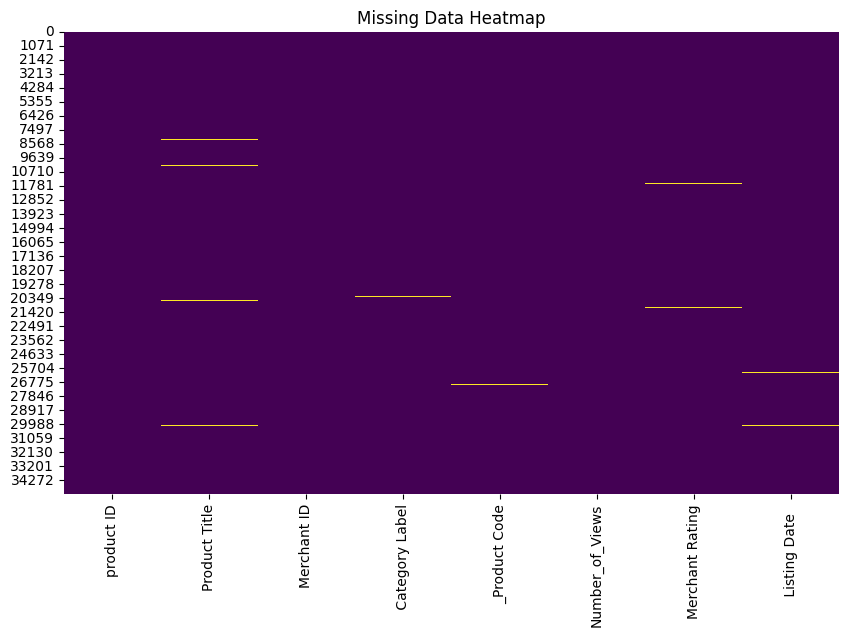

In [ ]:
# Visualize missing data with seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Visualize missing data with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

## Handle missing values
# Filling missing values with mean/median (for numeric columns)

- **`df.select_dtypes(include=['float64', 'int64'])`**: This line selects all numeric columns from the DataFrame (`df`), which are of type `float64` (floating-point numbers) and `int64` (integers).
  
- **`median_value = df[col].mean()`**: Calculates the median of the selected numeric column.

- **`df[col].fillna(median_value, inplace=True)`**: Fills the missing values in that column with the computed mean directly in the DataFrame.

In [ ]:
# Filling missing values with mean/median (for numeric columns)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    median_value = df[col].median()
    df[col].fillna(median_value)

# Filling categorical columns with the mode

- **`df.select_dtypes(include=['object'])`**: This identifies all categorical columns (usually represented as strings) in the DataFrame.

- **`mode_value = df[col].mode()[0]`**: The `.mode()` method returns a Series of the most frequent values. `[0]` retrieves the first mode if there are multiple modes.

- **`df[col].fillna(mode_value, inplace=True)`**: This line fills in the missing values within categorical columns based on the determined mode

The mode is a statistical measure that represents the most frequently occurring value in a dataset. It is one of the measures of central tendency, alongside the mean (average) and median (middle value).

In [ ]:
# Filling categorical columns with the mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value)

In [ ]:
# Verify if there are any missing values left
print("\nMissing values after handling:")
print(df.isna().sum())


Missing values after handling:
product ID         0
Product Title      0
Merchant ID        0
 Category Label    0
_Product Code      0
Number_of_Views    0
Merchant Rating    0
 Listing Date      0
dtype: int64


# Removing missing values

We will simply drop all rows that contain missing values, and check the new shape oand count missing values per column.

In [48]:
# Drop all rows with missing values
df = df.dropna()

# Display new shape of the dataset
print("New dataset shape:", df.shape)

# Count missing values per column
print("Missing values per column:")
print(df.isna().sum())

New dataset shape: (34760, 8)
Missing values per column:
product id         0
product title      0
merchant id        0
category label     0
_product code      0
number_of_views    0
merchant rating    0
listing date       0
dtype: int64


In [45]:
df = pd.read_csv(url)

# Count the number of rows before removing missing values
rows_before = len(df)

# Filter out rows that contain at least one missing value
rows_with_nan = df[df.isnull().any(axis=1)]

# Display a random sample of rows that will be removed
print(" Randomly selected rows containing missing values:\n")
print(rows_with_nan.sample(n=min(15, len(rows_with_nan)), random_state=42))

# Remove rows with any missing values
df_cleaned = df.dropna()

# Count the number of rows after removing missing values
rows_after = len(df_cleaned)

# Show removal statistics
print("\n Removal statistics:")
print(f"- Number of rows before: {rows_before}")
print(f"- Number of rows after: {rows_after}")
print(f"- Number of removed rows: {rows_before - rows_after}")

 Randomly selected rows containing missing values:

       product ID                                      Product Title  \
34920       46948                                                NaN   
5908        11926                                                NaN   
8613        14740                                                NaN   
5735        11746  lg hospitality display 55lv340c lcd tv 139 7 c...   
17299       27177       aeg fss62600p integrated 13 place dishwasher   
14527       24130                                                NaN   
27516       38697                                samsung rf24fsedbsr   
25671       36643     miele f 9122 ui 2 built in small freezer white   
5912        11930       toshiba 32w1633db 81.3 cm 32 led lcd tv 16 9   
19410       29562                                                NaN   
10877       17267  hewlett packard enterprise intel xeon e5640 fi...   
553           554                                                NaN   
5933        

## Removing irrelevant columns

Target variable would be the **Category Label**, and my input feature will be the **Product Title**.


### Explanation:
- **Input Feature**:
  - **Product Title**: This is the text that describes the product. Natural Language Processing (NLP) techniques can be used to analyze and extract features from this title.

- **Target Variable**:
  - **Category Label**: This is what you're trying to predict based on the Product Title. It classifies the product into specific categories.

### Excluding Columns:
You should not use the following columns as features for this prediction task:
- **Product ID**: Identifier that does not provide useful information about the product.
- **Merchant ID**: Identifier irrelevant for categorizing the product itself.
- **Product Code**: Similar to IDs, it serves as an identifier.
- **Number of Views**: A metric that could be influenced by various factors but is not directly predictive of the category.
- **Listing Date**: Date-related information that doesn't help classify the title.
- **Merchant Rating**: This reflects customer feedback but doesn’t assist in determining the product category.

In [53]:
# Drop columns that are not useful for modeling
df = df.drop(columns=['product id', 'merchant id', '_product code', 'number_of_views', 'merchant rating', 'listing date' ])

# Preview remaining columns
print("Remaining columns:")
print(df.columns.tolist())

Remaining columns:
['product title', 'category label']


# Train logistic regression model

### Libraries Imported
- **`from sklearn.feature_extraction.text import TfidfVectorizer`**: This is used to convert a collection of raw documents (in this case, product titles) into a matrix of TF-IDF features. TF-IDF stands for Term Frequency-Inverse Document Frequency, a common technique in text mining.
  
- **`from sklearn.linear_model import LogisticRegression`**: This imports the Logistic Regression class from Sci-kit Learn, which is used for classification tasks.

### Code Components
1. **Loading Data**:
   - Loading a dataset consisting of product titles and corresponding category labels.

2. **Preprocessing**:
   - It appears there's a step involving handling missing values in the dataset (`data.fillna`). This is important to ensure that the data is clean before training the model.

3. **Feature Extraction**:
   - The titles are converted into numerical data using the TfidfVectorizer. This transformation helps machine learning models understand the textual data in a format they can process.

4. **Model Initialization**:
   - Logistic Regression is initialized to create a model that will be trained on the features extracted from the product titles.

5. **Model Training**:
   - There’s an implication that the model will be fitted to the training data, allowing it to learn the relationship between the product titles and their respective categories.

6. **Input for Predictions**:
   - The script includes a part that allows users to enter a new product title, which the model will classify into a specific category.

7. **Output**:
   - The model outputs the predicted category for the input product title, indicating how well the model understands the text data.

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Load the labeled dataset with product titles and categories
data = pd.read_csv('cleaned_data.csv')

# Drop rows with missing values in either 'product title' or 'category label'
data.dropna(subset=['product title', 'category label'], inplace=True)

X = data['product title']
y = data['category label']

# Vectorize all product titles
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_vectorized, y)

# Loop for user input
print("Model is ready. Enter a product title to classify its category.")
while True:
    user_input = input("Enter a product title ('exit' to quit): ")
    if user_input.lower() == 'exit':
        break

    # Transform user input to match TF-IDF vector format
    user_vectorized = vectorizer.transform([user_input])
    predicted_category = model.predict(user_vectorized)

    print(f"Predicted category: {predicted_category[0]}")

Model is ready. Enter a product title to classify its category.
Enter a product title ('exit' to quit): kenwood k20mss15 solo
Predicted category: microwaves
Enter a product title ('exit' to quit): bosch wap28390gb 8kg 1400 spin
Predicted category: washing machines
Enter a product title ('exit' to quit): smeg sbs8004po
Predicted category: fridges
Enter a product title ('exit' to quit): iphone 7 32gb gold,4,3,Apple iPhone 7 32GB
Predicted category: mobile phones
Enter a product title ('exit' to quit): exit


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define Features and Target
X = df['product title'] # Text feature
y = df['category label'] # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_combined = X_train_tfidf
X_test_combined = X_test_tfidf

# Define and Train Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_combined, y_train)

#Make predictions
predicitions = model.predict(X_test_combined)

# Evaluate Model
y_pred = model.predict(X_test_combined)
print(classification_report(y_test, y_pred))

# Function to classify new product title
def classify_product_title(title):
    title_tfidf = tfidf.transform([title])
    prediction = model.predict(title_tfidf)
    return prediction[0]

# Example usage
new_title = "iphone"
category = classify_product_title(new_title)
print(f"The product '{new_title}' falls into category: {category}")

### Components of the Confusion Matrix

1. **True Positives (TP)**: The count where the model correctly predicted the positive class. This is represented in the quadrant where true labels are positive and predicted labels are also positive.

2. **True Negatives (TN)**: The count where the model correctly predicted the negative class. This is located in the quadrant where true labels are negative and predicted labels are also negative.

3. **False Positives (FP)**: The count where the model incorrectly predicted the positive class (i.e., it predicted positive but the actual label was negative). This is found in the quadrant for negative true labels but positive predicted labels.

4. **False Negatives (FN)**: The count where the model incorrectly predicted the negative class (i.e., it predicted negative but the actual label was positive). This appears in the quadrant for positive true labels but negative predicted labels.




Unique labels in y_test: ['microwaves' 'washing machines' 'fridge freezers' 'digital cameras'
 'mobile phones' 'fridges' 'cpus' 'dishwashers' 'tvs' 'freezers' 'fridge'
 'cpu' 'mobile phone' 'nan']


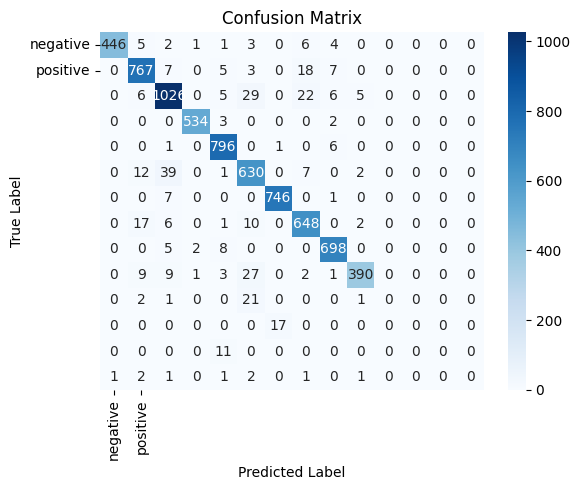

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Define Features and Target
X = df['product title'] # Text feature
y = df['category label'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.2, random_state=42, stratify=y

)

# Vectorization and model training

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

print("Unique labels in y_test:", y_test.unique())
unique_labels = y_test.unique()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Plot using seaborn

plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])

plt.xlabel("Predicted Label")

plt.ylabel("True Label")

plt.title("Confusion Matrix")

plt.tight_layout()

plt.show()


### Matrix Breakdown

From the matrix:

- **True Negatives (TN)**: 446 (Predicted Negative when actually Negative)
- **False Positives (FP)**: 5 (Predicted Positive when actually Negative)
- **False Negatives (FN)**: 767 (Predicted Negative when actually Positive)
- **True Positives (TP)**: 102 (Predicted Positive when actually Positive)

#### Performance Metrics:
1. **Accuracy**: This measures the overall correctness of the model.
   \[
   \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
   \]
   In this case, that would be:
   \[
   \text{Accuracy} = \frac{102 + 446}{102 + 446 + 5 + 767} = \frac{548}{1320} \approx 0.415 (or 41.5\%)
   \]

2. **Precision**: This measures the accuracy of positive predictions.
   \[
   \text{Precision} = \frac{TP}{TP + FP} = \frac{102}{102 + 5} \approx 0.953 (or 95.3\%)
   \]

3. **Recall (Sensitivity)**: This measures the model’s ability to find all the relevant cases (actual positives).
   \[
   \text{Recall} = \frac{TP}{TP + FN} = \frac{102}{102 + 767} \approx 0.117 (or 11.7\%)
   \]

4. **F1 Score**: This is the harmonic mean of precision and recall, providing a balance between the two.
   \[
   F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
   \]
